In [26]:
import numpy as np
from Models.utils import PrimalDualSolver_l2, ProjectedGradientDescent_l2

class SDL_simple:
    """
    Supervised Dictionary Learning (SDL) Class.

    Combines sparse coding with supervised learning by jointly learning:
    - A dictionary `D` for sparse representation.
    - A linear model `(theta, b)` for predicting labels.
    """

    def __init__(self, n_iter=10,
                 lamnda0=0.01,
                 lambda1=0.01,
                 lambda2=0.01,
                 lr_D=0.01,
                 lr_theta=0.01,
                 lr_alpha=0.01):
        self.n_iter = n_iter
        self.lamnda0 = lamnda0
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lr_D = lr_D
        self.lr_theta = lr_theta
        self.lr_alpha = lr_alpha

    def objective(self, X, y, D, theta, b, alpha):
        """Computes the objective function value with separate terms."""
        total_loss_dict = 0
        total_loss_class = 0
        total_sparse_penalty = 0

        for i in range(X.shape[0]):
            xi, yi, ai = X[i], y[i], alpha[i]

            # Compute each term
            loss_dict = np.linalg.norm(xi - D @ ai)**2
            loss_class = np.linalg.norm(yi - (theta @ ai + b))**2
            sparse_penalty = self.lambda1 * np.linalg.norm(ai, 1)

            # Accumulate terms
            total_loss_dict += loss_dict
            total_loss_class += loss_class
            total_sparse_penalty += sparse_penalty

        # Combine the terms
        total_objective = total_loss_dict + total_loss_class + total_sparse_penalty
        return total_objective

    def solve_alpha(self, X, y, D, theta, b):
        """Optimizes sparse codes `alpha` for fixed `D` and `theta`."""
        n_samples, n_features = X.shape
        alpha = np.zeros((n_samples, n_features))

        for i in range(n_samples):
            x_i = X[i]
            y_i = y[i]

            solver = PrimalDualSolver_l2(
                theta=theta, b=b, x_i=x_i, y_i=y_i, D=D,
                lambda_0=self.lamnda0, lambda_1=self.lambda1,
                lambd=0.01, mu=1.0
            )
            # Solve the problem
            x0 = np.random.randn(n_features)  # Random initialization
            alpha_opt, _ = solver.solve(x0)

            alpha[i] = alpha_opt

        return alpha

    def solve_D_theta(self, alpha_opt, X, y, D_opt, theta_opt, b):
        """Updates `D` and `theta` given the optimal `alpha`."""
        pgd = ProjectedGradientDescent_l2(
            D_init=D_opt, theta_init=theta_opt,
            b=b, x=X, y=y, alphas=alpha_opt,
            lambda_0=self.lamnda0,
            lambda_1=self.lambda1, lambda_2=self.lambda2,
            lr=self.lr_D, max_iter=self.n_iter
        )
        D_opt, theta_opt, b_opt, _ = pgd.optimize()
        return D_opt, theta_opt, b_opt

    def fit(self, X, y):
        """Fits the model to the data."""
        n_samples, n_features = X.shape
        self.n_components = n_features
        D_opt = np.random.randn(n_features, self.n_components)
        D_opt /= np.linalg.norm(D_opt, axis=0)
        theta_opt = np.zeros(self.n_components)
        b_opt = 0

        for i in range(self.n_iter):
            alpha_opt = self.solve_alpha(X, y, D_opt, theta_opt, b_opt)
            D_opt, theta_opt, b_opt = self.solve_D_theta(alpha_opt,
                                                            X,
                                                            y,
                                                            D_opt,
                                                            theta_opt,
                                                            b_opt)
            # Compute the loss
            loss = self.objective(X, y, D_opt, theta_opt, b_opt, alpha_opt)
            print(f"Iteration {i+1}/{self.n_iter}, Loss: {loss}")

            # Stop the model if the loss is NaN
            if np.isnan(loss):
                print("Loss is NaN. Stopping optimization.")
                break

        self.alpha = alpha_opt
        self.D = D_opt
        self.theta = theta_opt
        self.b = b_opt

    def predict(self, X):
        """Predicts labels for input data `X`."""
        return self.theta @ self.alpha.T + self.b

    def score(self, X, y):
        """Computes classification accuracy."""
        y_pred = self.predict(X)
        return np.mean(np.round(y_pred) == y)


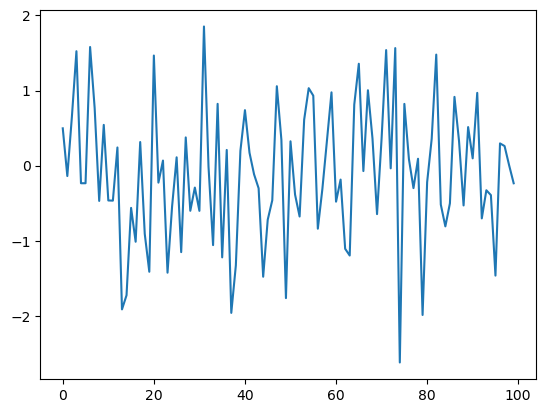

Loss Dictionary: 10037.839233348097, Loss Classification: 52597.452157412765, Sparse Penalty: 18.048388843824156
Iteration 1/10, Loss: 62653.339779604685
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 2/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 3/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 4/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 5/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 6/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 7/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 8/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 9/10, Loss: nan
Loss Dictionary: nan, Loss Classification: nan, Sparse Penalty: nan
Iteration 10/10, Loss: nan

In [24]:

# Generate synthetic data
np.random.seed(42)
n_samples, n_features, n_components = 100, 100, 10
X = np.random.randn(n_samples, n_features)  # Input data
true_D = np.random.randn(n_features, n_components)  # True dictionary
true_alpha = np.random.randn(n_samples, n_components)  # Sparse codes
true_theta = np.random.randn(n_components)  # Linear model weights
b_true = 0.5  # Bias term


# Generate labels based on the linear model
y = X @ true_D @ true_theta + b_true + 0.1 * np.random.randn(n_samples)
y = np.round(y)  # Binary classification labels (0 or 1)

# do a plot of X[0]
import matplotlib.pyplot as plt
plt.plot(X[0])
plt.show()




# Initialize the SDL model
sdl = SDL_simple(
    n_iter=10,
    lamnda0=0.01,
    lambda1=0.2,
    lambda2=0.1,
    lr_D=0.01,
    lr_theta=0.01,
    lr_alpha=0.01
)

# Fit the model to the data
sdl.fit(X, y)

# Evaluate the model
accuracy = sdl.score(X, y)
print(f"Classification Accuracy: {accuracy:.2f}")


In [ ]:
from itertools import product

def select_best_lambda(X, y, lambda0_range, lambda2_range, n_iter=10):
    """
    Selects the best lambda parameters for the SDL model using grid search with a fixed ratio between lambda1 and lambda0.

    Parameters:
    - X, y: Dataset for training and evaluation.
    - lambda0_range: Range of values to test for lambda0.
    - lambda2_range: Range of values to test for lambda2.
    - n_iter: Number of iterations for the SDL model.

    Returns:
    - best_params: Dictionary with the best lambda parameters.
    - best_accuracy: Highest accuracy achieved.
    """
    best_accuracy = -float('inf')
    best_params = {}

    # Total number of combinations to evaluate
    total_combinations = len(lambda0_range) * len(lambda2_range)
    combination_count = 0

    for lambda0 in lambda0_range:
        # Calculate lambda1 such that lambda1/lambda0 is approximately 0.15
        lambda1 = 0.15 * lambda0

        for lambda2 in lambda2_range:
            # Increment the combination counter
            combination_count += 1

            # Initialize and fit the SDL model
            sdl = SDL_simple(
                n_iter=n_iter,
                lamnda0=lambda0,
                lambda1=lambda1,
                lambda2=lambda2,
                lr_D=0.01,
                lr_theta=0.01,
                lr_alpha=0.01
            )
            sdl.fit(X, y)

            # Evaluate the model
            accuracy = sdl.score(X, y)
            print(f"Progress: {combination_count}/{total_combinations} ({(combination_count/total_combinations)*100:.2f}%)")
            print(f"Lambda0: {lambda0}, Lambda1: {lambda1}, Lambda2: {lambda2}, Accuracy: {accuracy:.2f}")

            # Update best parameters if the current accuracy is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lambda0': lambda0, 'lambda1': lambda1, 'lambda2': lambda2}

    print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.2f}")
    return best_params, best_accuracy

# Example usage
lambda0_range = [0.001, 0.01, 0.1]
lambda2_range = [0.01, 0.1, 0.5]

best_params, best_accuracy = select_best_lambda(X, y, lambda0_range, lambda2_range)


Iteration 1/10, Loss: 1.1684287799726756e+18
Iteration 2/10, Loss: nan
Loss is NaN. Stopping optimization.
Progress: 1/9 (11.11%)
Lambda0: 0.001, Lambda1: 0.00015, Lambda2: 0.01, Accuracy: 0.00
Iteration 1/10, Loss: 4.97218075101485e+18
Iteration 2/10, Loss: nan
Loss is NaN. Stopping optimization.
Progress: 2/9 (22.22%)
Lambda0: 0.001, Lambda1: 0.00015, Lambda2: 0.1, Accuracy: 0.00
Iteration 1/10, Loss: 1.165640867570814e+19
Iteration 2/10, Loss: nan
Loss is NaN. Stopping optimization.
Progress: 3/9 (33.33%)
Lambda0: 0.001, Lambda1: 0.00015, Lambda2: 0.5, Accuracy: 0.00
Iteration 1/10, Loss: 2.3774320407994588e+16
Iteration 2/10, Loss: nan
Loss is NaN. Stopping optimization.
Progress: 4/9 (44.44%)
Lambda0: 0.01, Lambda1: 0.0015, Lambda2: 0.01, Accuracy: 0.00
Iteration 1/10, Loss: 1.1542095178796981e+17
Iteration 2/10, Loss: nan
Loss is NaN. Stopping optimization.
Progress: 5/9 (55.56%)
Lambda0: 0.01, Lambda1: 0.0015, Lambda2: 0.1, Accuracy: 0.00
Iteration 1/10, Loss: 9.281626360061822e